In [47]:
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset
from tqdm import tqdm

from models.seq2seq.seq2seq_net import Seq2Seq

In [48]:
class Config:
    data_path = './data/serverless/cached/queue_id_{}.csv'.format(36)
    timestep = 12  # 时间步长，就是利用多少时间窗口
    batch_size = 32  # 批次大小
    feature_size = 7  # 每个步长对应的特征数量
    hidden_size = 256  # 隐层大小
    output_size = 2  # 由于是多输出任务，最终输出层大小为6，预测未来6个时间段的负载数据
    num_layers = 2  # lstm的层数
    epochs = 100  # 迭代轮数
    best_loss = 0.010  # 记录损失
    learning_rate = 0.0003  # 学习率
    model_name = 'seq2seq'  # 模型名称
    save_path = './checkpoints/{}.pth'.format(model_name)  # 最优模型保存路径


config = Config()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("use {} train".format(device))

use cuda train


In [49]:
# 1.加载时间序列数据
df = pd.read_csv(config.data_path, index_col=0)

# 填充空值
print(df.shape)
print(df.head())
print(df.info())
print(df.describe())

df.drop(['STATUS', 'PLATFORM', 'RESOURCE_TYPE', 'DISK_USAGE', 'SJOB', 'CJOB', 'FJOB'], axis=1,
        inplace=True)
# 调整顺序
new_order = ['CPU_USAGE', 'QUEUE_ID', 'CU', 'QUEUE_TYPE', 'MEM_USAGE', 'LJOB', 'RJOB']
df = df[new_order]
# 七个特征
print(df.head())

(3242, 14)
               QUEUE_ID  CU  STATUS  QUEUE_TYPE  PLATFORM  CPU_USAGE  \
timestamp                                                              
1591268040000        36  16       2           0         1         32   
1591268340000        36  16       2           0         1          3   
1591268640000        36  16       2           0         1          5   
1591268940000        36  16       2           0         1          2   
1591269240000        36  16       2           0         1         15   

               MEM_USAGE  LJOB  RJOB  SJOB  CJOB  FJOB  RESOURCE_TYPE  \
timestamp                                                               
1591268040000         17     0     0     1     0     0              1   
1591268340000         18     0     0     0     0     0              1   
1591268640000         18     0     0     0     0     0              1   
1591268940000         18     0     0     0     0     0              1   
1591269240000         19     0     0     2    

In [53]:
# 2.将数据进行标准化
scaler = MinMaxScaler()
scaler_model = MinMaxScaler()
data: np.ndarray = scaler_model.fit_transform(np.array(df))
# only display
scaler.fit_transform(np.array(df['CPU_USAGE']).reshape(-1, 1))

display(data)

array([[0.4025974 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02597403, 0.        , 0.        , ..., 0.01265823, 0.        ,
        0.        ],
       [0.05194805, 0.        , 0.        , ..., 0.01265823, 0.        ,
        0.        ],
       ...,
       [0.01298701, 0.        , 0.        , ..., 0.94936709, 0.        ,
        0.        ],
       [0.01298701, 0.        , 0.        , ..., 0.94936709, 0.        ,
        0.        ],
       [0.02597403, 0.        , 0.        , ..., 0.94936709, 0.        ,
        0.        ]])

In [57]:
idx = 1
print(data[idx + config.timestep: idx + config.timestep + config.output_size])
print(data[idx + config.timestep: idx + config.timestep + config.output_size][:, 0])
print(data[idx + config.timestep: idx + config.timestep + config.output_size][:, 0].tolist())

[[0.06493506 0.         0.         0.         0.05063291 0.
  0.        ]
 [0.05194805 0.         0.         0.         0.06329114 0.
  0.        ]]
[0.06493506 0.05194805]
[0.06493506493506493, 0.05194805194805195]


In [41]:
# 形成训练数据，例如12345789 12345-67 23456-78
def split_data(data: np.ndarray, timestep, feature_size, output_size):
    dataX = []  # 保存X
    dataY = []  # 保存Y

    # 将整个窗口的数据保存到X中，将未来一天保存到Y中
    for index in range(len(data) - timestep - 1):
        dataX.append(data[index: index + timestep])
        dataY.append(data[index + timestep: index + timestep + output_size][:, 0].tolist())

    dataX = np.array(dataX)
    dataY = np.array(dataY)

    # 获取训练集大小
    train_size = int(np.round(0.8 * dataX.shape[0]))

    # 划分训练集、测试集
    x_train = dataX[: train_size, :].reshape(-1, timestep, feature_size)
    y_train = dataY[: train_size].reshape(-1, output_size)

    x_test = dataX[train_size:, :].reshape(-1, timestep, feature_size)
    y_test = dataY[train_size:].reshape(-1, output_size)

    return [x_train, y_train, x_test, y_test]


# 3.获取训练数据   
# x_train: train_len,timestep,feature_size   y_train: train_len,output_size
# x_test: test_len,timestep,feature_size   y_test: test_len,output_size
x_train, y_train, x_test, y_test = split_data(data, config.timestep, config.feature_size, config.output_size)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2583, 12, 7)
(2583, 2)
(646, 12, 7)
(646, 2)


In [42]:
# 4.将数据转为tensor
x_train_tensor = torch.from_numpy(x_train).to(torch.float32)
y_train_tensor = torch.from_numpy(y_train).to(torch.float32)
x_test_tensor = torch.from_numpy(x_test).to(torch.float32)
y_test_tensor = torch.from_numpy(y_test).to(torch.float32)

# 5.形成训练数据集
train_data = TensorDataset(x_train_tensor, y_train_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)

# 6.将数据加载成迭代器
train_loader = torch.utils.data.DataLoader(train_data,
                                           config.batch_size,
                                           False)

test_loader = torch.utils.data.DataLoader(test_data,
                                          config.batch_size,
                                          False)

In [43]:
model = Seq2Seq(config.feature_size, config.hidden_size, config.num_layers, config.output_size)
model = model.to(device)
loss_function = nn.MSELoss()  # 定义损失函数
loss_function = loss_function.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)  # 定义优化器

In [44]:
# 8.模型训练
for epoch in range(config.epochs):
    model.train()
    running_loss = 0
    train_bar = tqdm(train_loader)  # 形成进度条
    for data in train_bar:
        x_train, y_train = data  # 解包迭代器中的X和Y
        x_train: torch.Tensor = x_train.to(device)
        y_train: torch.Tensor = y_train.to(device)
        optimizer.zero_grad()
        y_train_pred = model(x_train)
        loss = loss_function(y_train_pred, y_train)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 config.epochs,
                                                                 loss)

    # 模型验证
    model.eval()
    test_loss = 0
    with torch.no_grad():
        test_bar = tqdm(test_loader)
        for data in test_bar:
            x_test, y_test = data
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            # x_test: [batchSize, timestep, featureSize]
            # y_test_pred: [batchSize, outputSize]
            y_test_pred = model(x_test)
            test_loss = loss_function(y_test_pred, y_test)

    if test_loss <= config.best_loss:
        config.best_loss = test_loss
        print('best loss is {}, saving model'.format(config.best_loss))
        torch.save(model.state_dict(), config.save_path)

    gc.collect()
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()

print('Finished Training')

100%|██████████| 21/21 [00:00<00:00, 658.12it/s]


best loss is 0.0015420117415487766, saving model


100%|██████████| 21/21 [00:00<00:00, 508.52it/s]


best loss is 0.0014766388339921832, saving model


100%|██████████| 21/21 [00:00<00:00, 509.74it/s]


best loss is 0.0013956519542261958, saving model


100%|██████████| 21/21 [00:00<00:00, 585.66it/s]


best loss is 0.0013619707897305489, saving model


100%|██████████| 21/21 [00:00<00:00, 627.17it/s]


best loss is 0.0013274296652525663, saving model


100%|██████████| 21/21 [00:00<00:00, 576.72it/s]

Finished Training


torch.Size([2583, 2])


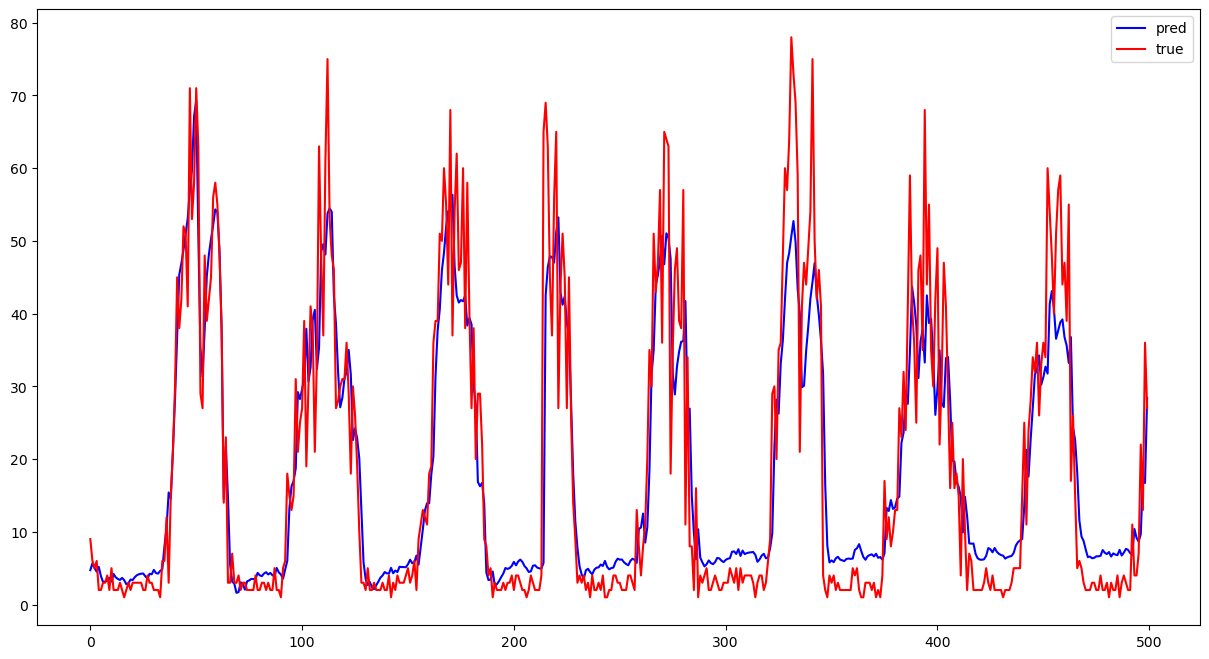

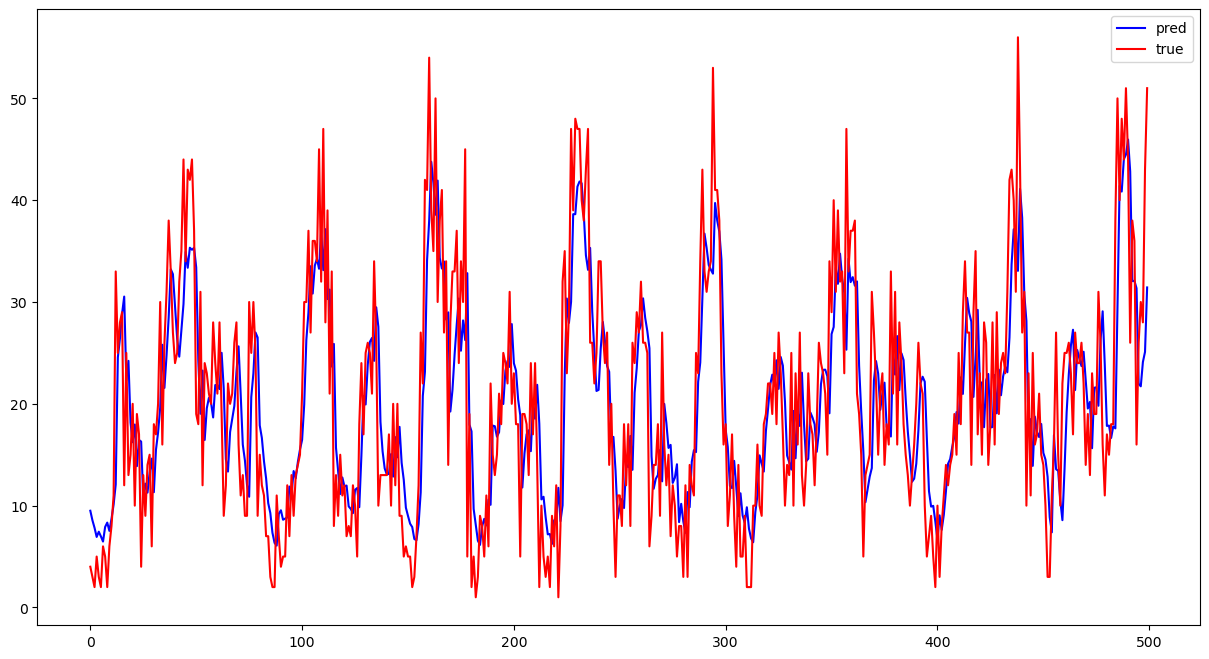

In [46]:
# 9.绘制结果
gc.collect()
if hasattr(torch.cuda, 'empty_cache'):
    torch.cuda.empty_cache()

# 显示多少时间步的数据，太多容易看不清
plot_size = 500
# 预测哪个时间范围的数据
train_pred_range = [0, 3000]
test_pred_range = [0, 600]

x_train_pred = model(x_train_tensor[train_pred_range[0]:train_pred_range[1]].to(device))
print(x_train_pred.shape)
plt.figure(figsize=(15, 8))
plt.plot(
    scaler.inverse_transform(
        (x_train_pred.detach().cpu().numpy()[
         : plot_size, 0]).reshape(-1, 1)),
    label='pred', color='blue')
plt.plot(
    scaler.inverse_transform(
        y_train_tensor[train_pred_range[0]:train_pred_range[1]].detach().numpy()[: plot_size, 0].reshape(-1, 1)),
    label='true',
    color='red')
plt.legend()
plt.show()

y_test_pred = model(x_test_tensor[test_pred_range[0]:test_pred_range[1]].to(device))
plt.figure(figsize=(15, 8))
plt.plot(scaler.inverse_transform(y_test_pred.detach().cpu().numpy()[: plot_size, 0].reshape(-1, 1)), label='pred',
         color='blue')
plt.plot(
    scaler.inverse_transform(
        y_test_tensor[test_pred_range[0]:test_pred_range[1]].detach().numpy()[: plot_size, 0].reshape(-1, 1)),
    label='true',
    color='red')
plt.legend()
plt.show()
